### Demonstrating CAE-VIB model training with DeepHyper:

**Importing necessary packages**

In [1]:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior() 
  assert tf2.enabled()

import numpy as np
import tensorflow as tf


from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import math
import os

import matplotlib.pyplot as plt
import glob 

mode = 'train'   

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

import time
time1 = time.time()

Num GPUs: 1


**Defining data loading functions**

In [3]:
seed_value = 9
num_tot = 100
num_epochs = 200
nGrid= 128 
max_evals = 5 
dtype = 'non-rotated'


np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def shuffle(X, y):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y, shuffleOrder

def load_data_TrainTestVal(n):
    os.chdir('./Results_1/')
    dirIn0 = '../data/Data_split-' + dtype + '/Data_split/'
    dirIn1 = 'Data_Split_N'+str(n)+'/'
    dirIn = dirIn0 + dirIn1
    print(dirIn)
    print(glob.glob(dirIn + 'input_train_data*'))
    train_data = np.load(glob.glob(dirIn + 'input_train_data*')[0])
    train_target = np.load(glob.glob(dirIn + 'output_train_data*')[0])
    test_data = np.load(glob.glob(dirIn + 'input_test_data*')[0])
    test_target = np.load(glob.glob(dirIn + 'output_test_data*')[0])
    valid_data = np.load(glob.glob(dirIn + 'input_val_data*')[0])
    valid_target = np.load(glob.glob(dirIn + 'output_val_data*')[0]) 
    return (train_data, train_target), (test_data, test_target), (valid_data, valid_target)


def load_data_prepared():
    (train_input, train_target), (test_input, test_target), (valid_input, valid_target) = load_data_TrainTestVal(num_tot)
    tmin = train_input.min()    
    tmax = train_input.max()
    train_images = (train_input - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_images = (test_input - tmin) / (tmax - tmin)
    valid_images = (valid_input - tmin) / (tmax - tmin)
    shape0 = train_images.shape[0]
    swe_train_data = train_images.reshape(shape0, nGrid, nGrid, 1)
    shape0 = test_images.shape[0]
    swe_test_data = test_images.reshape(shape0, nGrid, nGrid, 1)   
    shape0 = valid_images.shape[0]
    swe_valid_data = valid_images.reshape(shape0, nGrid, nGrid, 1)        
    ############################################    
    tmin = train_target.min()    
    tmax = train_target.max()
    train_target = (train_target - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_target = (test_target - tmin) / (tmax - tmin)
    valid_target = (valid_target - tmin) / (tmax - tmin)
    shape0 = train_target.shape[0]
    swe_train_target = train_target.reshape(shape0, nGrid, nGrid, 1)
    shape0 = test_target.shape[0]
    swe_test_target = test_target.reshape(shape0, nGrid, nGrid, 1)    
    shape0 = valid_target.shape[0]
    swe_valid_target = valid_target.reshape(shape0, nGrid, nGrid, 1)    
    return (swe_train_data, swe_train_target), (swe_test_data, swe_test_target), (swe_valid_data, swe_valid_target), (tmax, tmin)




**Loading the data**

In [4]:
(swe_train_data, swe_train_target), (swe_test_data, swe_test_target), (swe_valid_data, swe_valid_target), (tmax, tmin) = load_data_prepared()

../data/Data_split-non-rotated/Data_split/Data_Split_N100/
['../data/Data_split-non-rotated/Data_split/Data_Split_N100/input_train_data_90.npy']


**Defining necessary functions for the model**

In [5]:
def unscale(field):
    mx = (tmax - tmin)
    unscaled = (field*mx) + tmin 
    return unscaled

def sampling(z):
    return z[0] + z[1] * tf.random.normal(shape=z[0].shape, mean=0.0, stddev=1.0)
    

**Defining the model**

In [6]:
def build_and_train_model(config: dict, verbose: bool = 0,seed:int = 1):
    default_config = {
        "dense_width": 128,
        "decay_rate": 0.999,
        "decay_rate_steps": 1,
        "learning_rate": 1e-3,
        "batch_size": 8,
        "latent_dim": 32,
        "beta":10**(-2)
    }
    default_config.update(config)
    print(default_config)
    default_config["dense_width"] = int(default_config["dense_width"])
    default_config["latent_dim"] = int(default_config["latent_dim"])
    default_config["batch_size"] = int(default_config["batch_size"])
    ############### LOADING #############################################
    (swe_train_data, swe_train_target), (swe_test_data, swe_test_target), (swe_valid_data, swe_valid_target), (tmax, tmin) = load_data_prepared()
    ###### Encoder ###################
    encoder_inputs = Input(shape=(nGrid, nGrid, 1), name='Field')
    x= Conv2D(128, kernel_size=3, activation='relu', padding='same'
              ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(encoder_inputs)
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
              ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Flatten()(x)
    x= Dense(256,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Dense(default_config["dense_width"],kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    z_mean_sigma= Dense(2*default_config["latent_dim"], name='z_mean_sigma'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    encoder = Model(inputs=encoder_inputs, outputs=z_mean_sigma, name='encoder')
    ###### Decoder ################
    latent_inputs = Input(shape=(default_config["latent_dim"],), name='z_sampling')
    dim1 = 128
    x= Dense(default_config["dense_width"],kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(latent_inputs)
    x= Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x= Dense(dim1*dim1, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x= Reshape((dim1, dim1, 1))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    decoded = Conv2DTranspose(1, kernel_size=3, activation=None, padding='same'
                             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    decoder = Model(inputs=latent_inputs, outputs=decoded)
    ##########################################
    z_mean_sigma_out = encoder(encoder_inputs)
    print(z_mean_sigma_out.shape)
    mean_t = z_mean_sigma_out[:,:default_config["latent_dim"]]
    sigma_t = tf.keras.activations.softplus(z_mean_sigma_out[:,default_config["latent_dim"]:])
    print(mean_t.shape)
    print(sigma_t.shape)
    z_mean = mean_t + sigma_t * tf.random.normal(shape=(default_config["latent_dim"],), mean=0.0, stddev=1.0)
    ae_outputs = decoder(z_mean)
    ##########################################    
    def CustomLoss(y_true, y_pred, input_tensor,mean_t,sigma_t):
        conv_inp_out = y_pred*input_tensor
        mse = tf.keras.losses.MeanSquaredError()
        result = -0.5 * (1 + 2 * tf.math.log(sigma_t) - tf.math.pow(mean_t, 2) - tf.math.pow(sigma_t, 2))
        result_sum = tf.reduce_sum(result, axis=1)
        result_mean = tf.reduce_mean(result_sum)
        kl = result_mean / math.log(2)
        ITY = -0.5 * tf.math.log(mse(conv_inp_out, y_true))/tf.math.log(2.)
        return -ITY+ default_config["beta"]*kl  
    target = Input(shape=(nGrid, nGrid, 1), name='Field_target')
    model = Model(inputs=[encoder_inputs, target], outputs=ae_outputs, name='AE')    
    model.add_loss(CustomLoss( target, ae_outputs, encoder_inputs, mean_t,sigma_t ) )
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=default_config["learning_rate"],
                    decay_steps=default_config["decay_rate_steps"],
                    decay_rate=default_config["decay_rate"],staircase=True)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt)
    if mode == 'train':
        earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
        callbacks_list = (earlystopping)
        train_history = model.fit(x=[swe_train_data, swe_train_target], 
                                  y=None, 
                                  epochs=num_epochs, 
                                  batch_size=default_config["batch_size"], 
                                  callbacks=callbacks_list,
                                  verbose=verbose,
                                  validation_data=([swe_valid_data, swe_valid_target], None)).history    
    model = Model(model.input[0], model.output)
    #########################     
    swe_valid_pred = model.predict(swe_valid_data)[:, :, :, 0]    
    x = swe_valid_data[:, :, :, :]
    y_true = swe_valid_target[:, :, :, :]
    y_pred = swe_valid_pred[:, :, :, np.newaxis]*swe_valid_data[:, :, :, :]    
    metric_final = ((y_true - y_pred)**2).mean()
    return metric_final, train_history, model


**Defining the DeepHyper run function**

In [7]:
def run(config):
    # important to avoid memory explosion
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(10+seed_value)
    tf.config.experimental.enable_op_determinism()   
    metric_final, history, model = build_and_train_model(config, verbose=0,seed=seed_value)
    return -metric_final

**Defining hyperparameter space to be searched using DeepHyper** 

In [8]:
from deephyper.problem import HpProblem

problem = HpProblem()
problem.add_hyperparameter([32, 64, 128, 256], "dense_width", default_value=128)
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)
problem.add_hyperparameter((1e-5, 1, "log-uniform"), "decay_rate", default_value=0.999)
problem.add_hyperparameter([2, 4, 6, 8, 16], "batch_size", default_value=8)
problem.add_hyperparameter([16, 32, 64, 128, 256], "latent_dim", default_value=32)
problem.add_hyperparameter([10**i for i in range(-9,2,1)], "beta", default_value=10**(-4))
problem.add_hyperparameter([i for i in range(1,101,10)], "decay_rate_steps", default_value=1)
seed_value=2

**Running DeepHyper (5 evaluations for demonstration)**

In [ ]:
from deephyper.search.hps import CBO

randstring = 9
dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
dirOut2 = 'cbo-results_rdn' + str(randstring)

dirOut = dirOut0 + dirOut1 + dirOut2
os.makedirs(dirOut) if not os.path.exists(dirOut) else None

search = CBO(problem, run, initial_points=[problem.default_configuration], 
             log_dir=dirOut, 
             random_state=42)

results = search.search(max_evals=max_evals)

**Loading the best configuration from 100 DeepHyper evaluations**

In [7]:
best_config = {'batch_size': 16.0, 'beta': 0.001, 'decay_rate': 0.6157086900579446, 'decay_rate_steps': 71.0, 'dense_width': 256.0, 'latent_dim': 256.0, 'learning_rate': 0.0003380824712275}

**Rerunning the best model**

In [ ]:
seed_value=9
tf.keras.utils.set_random_seed(10+seed_value)
tf.config.experimental.enable_op_determinism()

metric_best, history_best, model_best  = build_and_train_model(
    config=best_config, verbose=1,seed=seed_value)
print(metric_best)

**Plotting the train and validation loss**

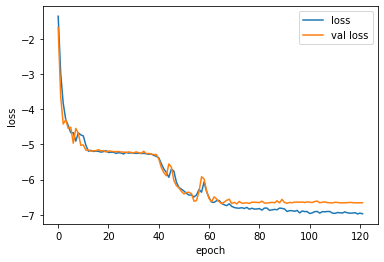

In [14]:
if mode == 'train':
    plt.figure(2111)
    plt.plot(history_best['loss'], label = 'loss')
    plt.plot(history_best['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

**Getting the model predictions**

In [15]:
swe_train_pred = model_best.predict(swe_train_data)[:, :, :, 0]
swe_test_pred = model_best.predict(swe_test_data)[:, :, :, 0]
swe_valid_pred = model_best.predict(swe_valid_data)[:, :, :, 0]

1/1 [==============================] - 0s 29ms/step


**Saving the model outputs**

In [17]:
import pickle

os.chdir('./Results_1/')

dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
Current_Model_directory = dirOut0 + dirOut1
Current_Model_directory

os.makedirs(Current_Model_directory) if not os.path.exists(Current_Model_directory) else None
os.chdir(Current_Model_directory)

file_name = "train.pkl"
with open(file_name,'wb') as file:
    pickle.dump(swe_train_pred,file)
    
file_name = "test.pkl"
with open(file_name,'wb') as file:
    pickle.dump(swe_test_pred,file)
    
file_name = "val.pkl"
with open(file_name,'wb') as file:
    pickle.dump(swe_valid_pred,file)

**For loading the model outputs (optional)**

In [20]:
import pickle
import os

os.chdir('./Results_1/')
randstring = 9
dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
dirOut2 = 'cbo-results_rdn' + str(randstring)

Current_Model_directory = dirOut0 + dirOut1 # where you want to save the plots
os.makedirs(Current_Model_directory) if not os.path.exists(Current_Model_directory) else None
os.chdir(Current_Model_directory)

file_name = "train.pkl"
with open(file_name,'rb') as file:
    swe_train_pred = pickle.load(file)
    
file_name = "test.pkl"
with open(file_name,'rb') as file:
    swe_test_pred = pickle.load(file)
    
file_name = "val.pkl"
with open(file_name,'rb') as file:
    swe_valid_pred = pickle.load(file)

**Generating the plots**

Please note that we use a subset of the test data set for demonstration

r2_p50_train 0.9069215395288049
nRMSE_p50_train 0.003341810224459515
r2_p90_train 0.4826421874045346
nRMSE_p90_train 0.014011573668548466
r2_p97_train 0.5059553895162665
nRMSE_p97_train 0.022008898633794533
r2_p99_train 0.43746116787379663
nRMSE_p99_train 0.03347323153020027
r2_p100_train 0.7053009521700566
nRMSE_p100_train 0.06313105352323613
r2_mean_train 0.9949633613065558
nRMSE_mean_train 0.003023338
r2_p50_val 0.6857830487031689
nRMSE_p50_val 0.009841567087625538
r2_p90_val -0.571742720511774
nRMSE_p90_val 0.01941801642445634
r2_p97_val -0.3794612056270923
nRMSE_p97_val 0.03394945919271267
r2_p99_val -1.0022836501111572
nRMSE_p99_val 0.056507016117064296
r2_p100_val 0.5208250539205678
nRMSE_p100_val 0.05576202115031349
r2_mean_val 0.9602699747079297
nRMSE_mean_val 0.008643141
r2_p50_test 0.5000423907597686
nRMSE_p50_test 0.008125260015235539
r2_p90_test 0.007842472182099325
nRMSE_p90_test 0.022364237877261897
r2_p97_test -0.08764955239322147
nRMSE_p97_test 0.03671029229303051
r2_p

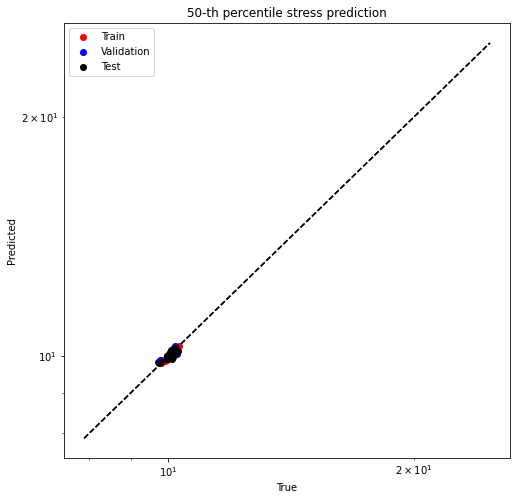

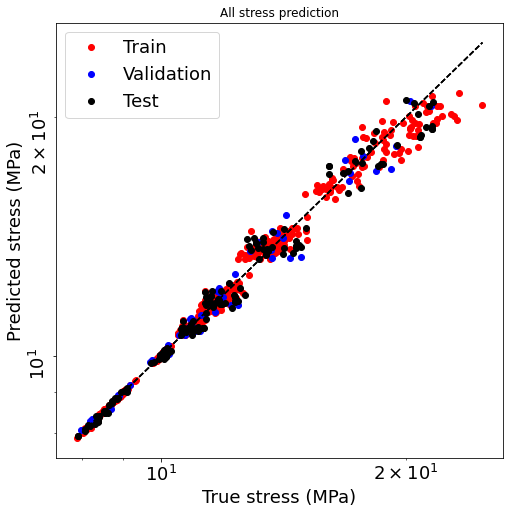

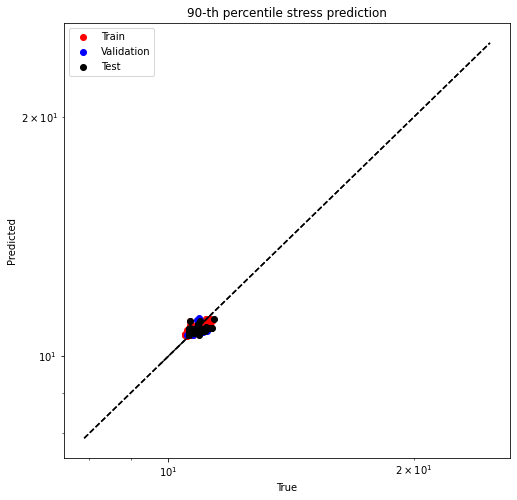

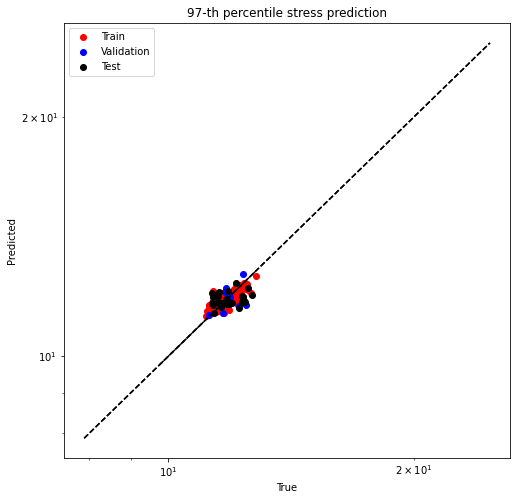

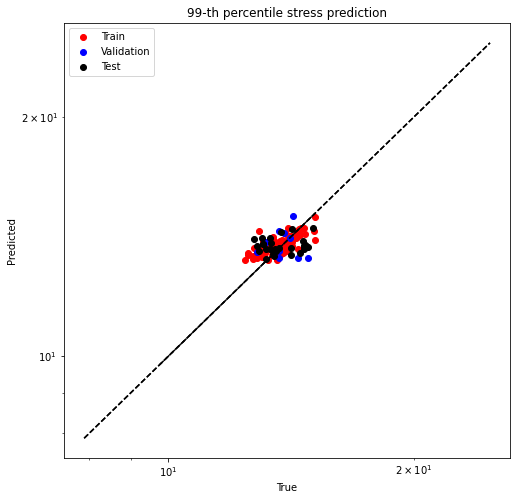

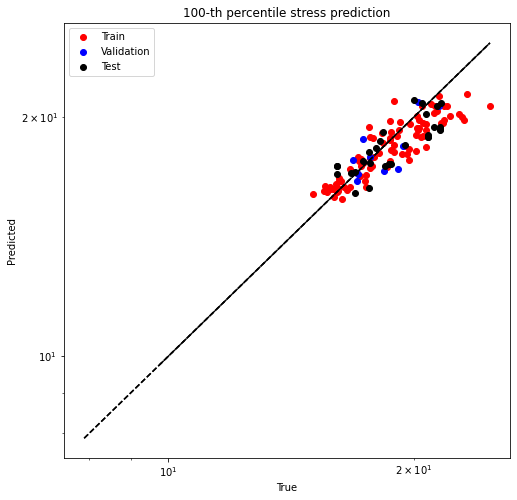

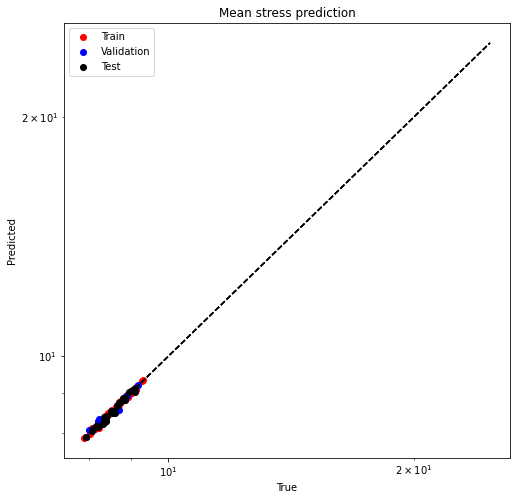

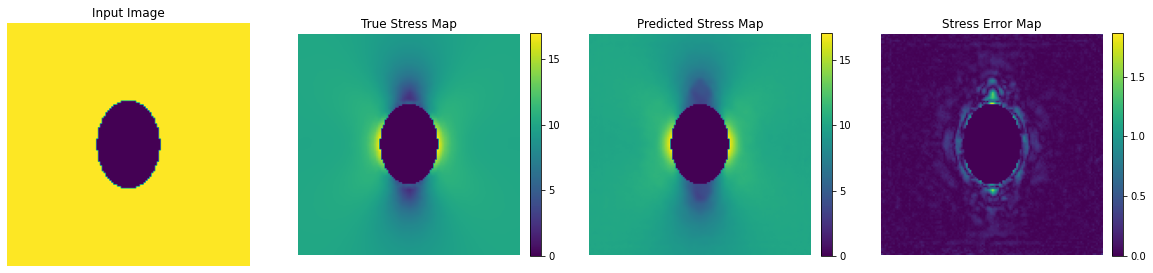

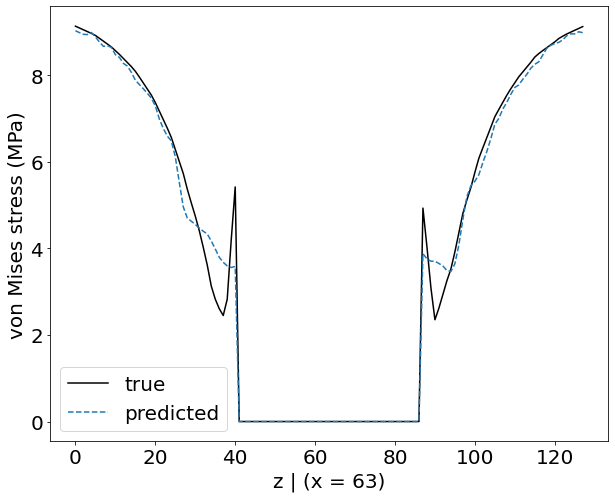

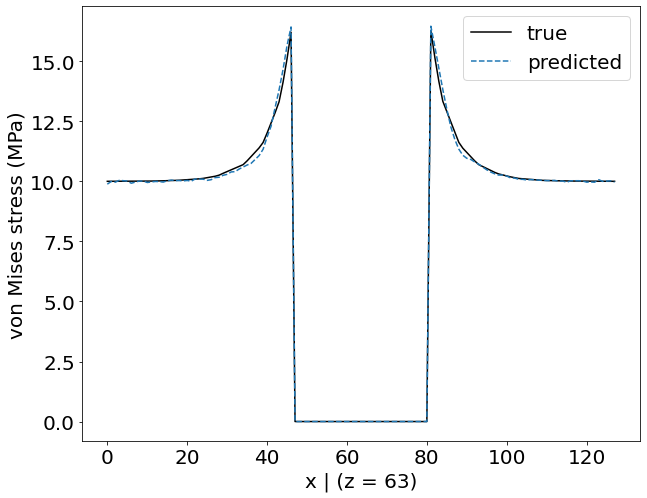

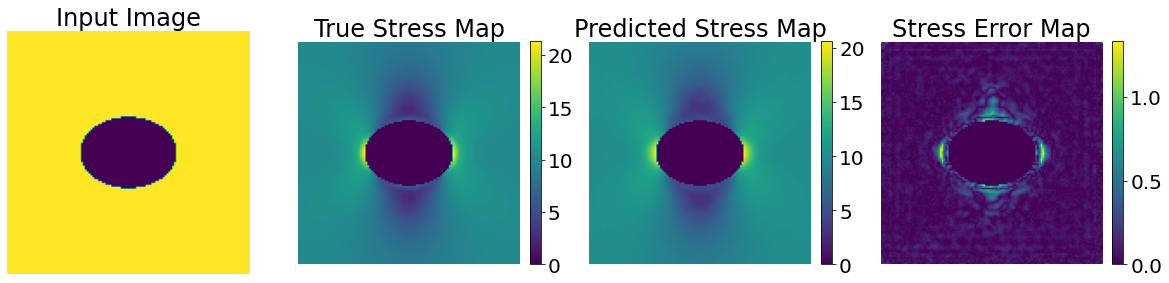

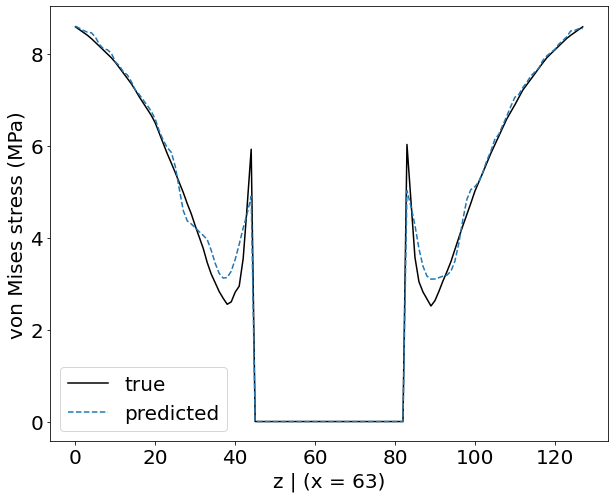

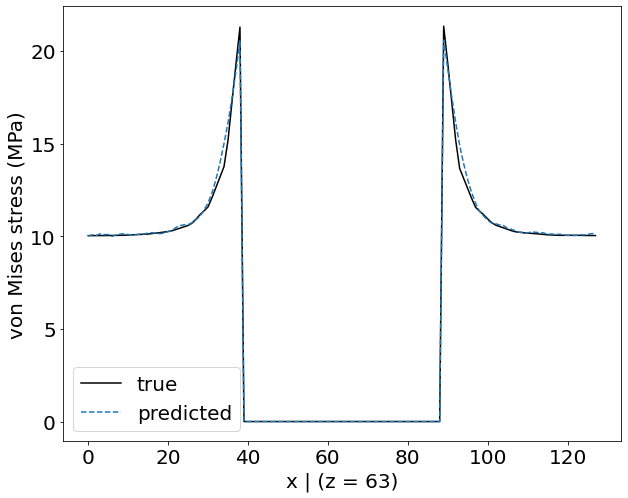

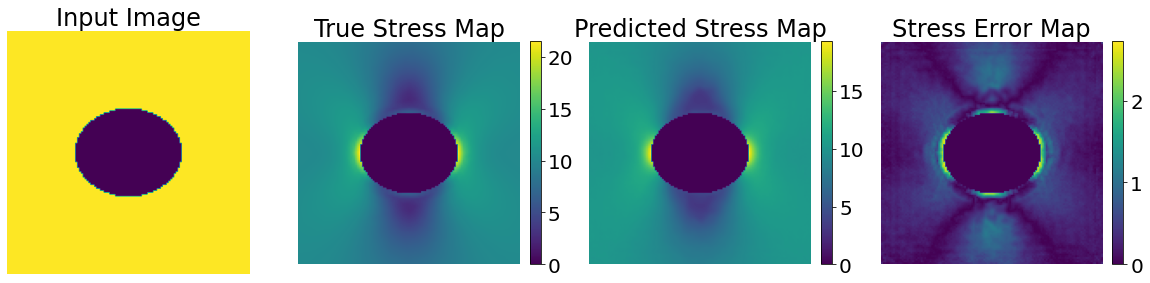

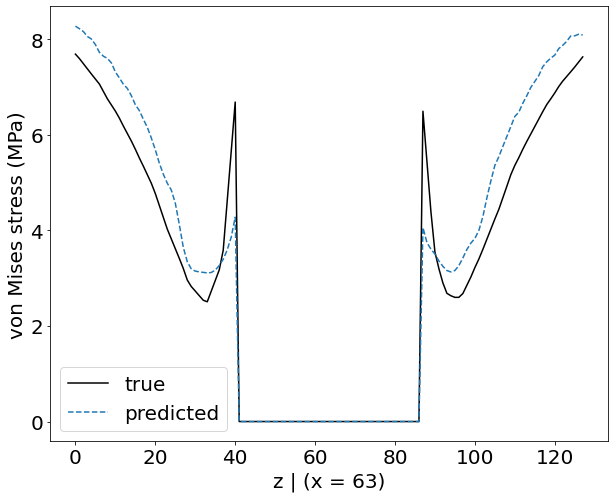

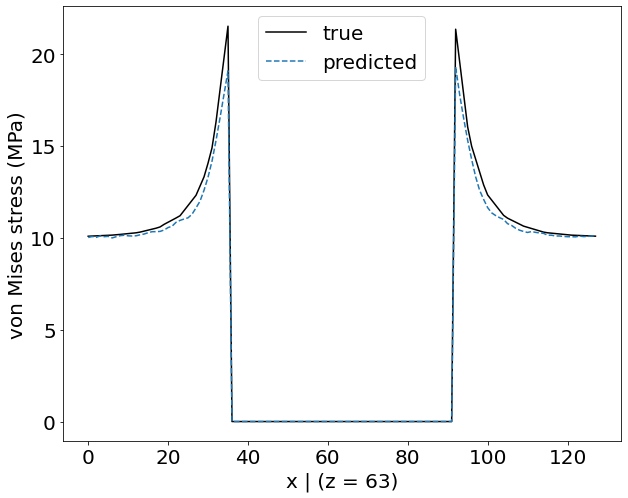

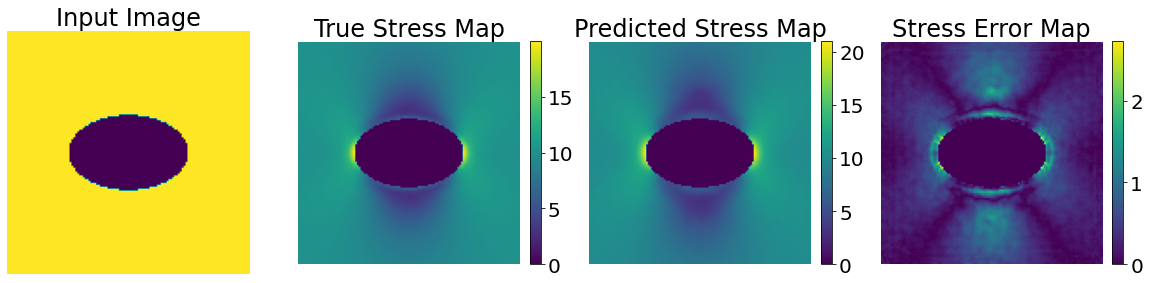

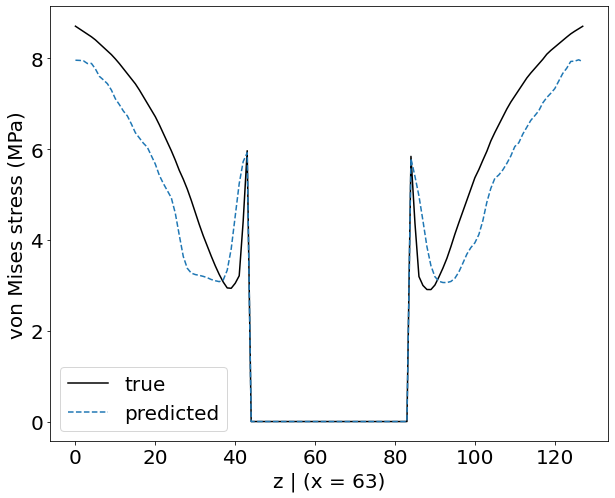

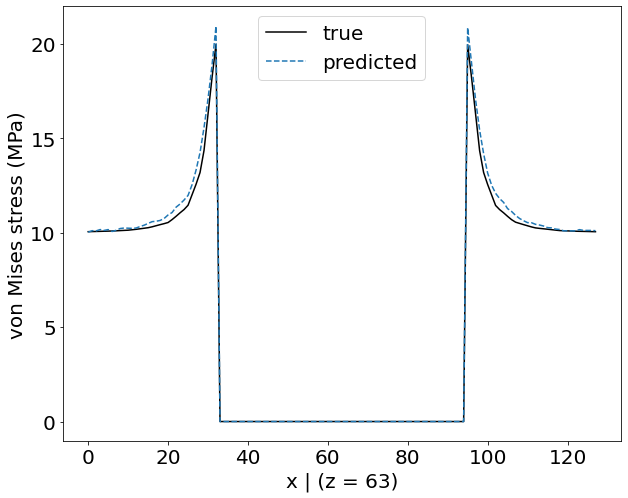

In [18]:
import numpy as np
from ErrorCalc_FunctionScript_v2 import error_calculation

os.chdir('./Results_1/')

randstring = 9
dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
dirOut2 = 'cbo-results_rdn' + str(randstring)

Current_Model_directory = dirOut0 + dirOut1 # where you want to save the plots
os.makedirs(Current_Model_directory) if not os.path.exists(Current_Model_directory) else None

file_str = 'error'
original_height = 128
original_width = 128


for dataset in ['train','val', 'test']:
    
    if dataset == 'test':
    
        x = swe_test_data[:, :, :, :]
        y_true = unscale(swe_test_target[:, :, :, :])
        y_pred = unscale(swe_test_pred[:, :, :, np.newaxis]*swe_test_data[:, :, :, :])
        
    elif dataset == 'val':
    
        x = swe_valid_data[:, :, :, :]
        y_true = unscale(swe_valid_target[:, :, :, :])
        y_pred = unscale(swe_valid_pred[:, :, :, np.newaxis]*swe_valid_data[:, :, :, :])
        
    elif dataset == 'train':
    
        x = swe_train_data[:, :, :, :]
        y_true = unscale(swe_train_target[:, :, :, :])
        y_pred = unscale(swe_train_pred[:, :, :, np.newaxis]*swe_train_data[:, :, :, :])
    
    error_calculation(dataset,
                      x,
                      y_true/1e6,
                      y_pred/1e6,
                      Current_Model_directory,
                      file_str,
                      original_height,
                      original_width)